# Loading Libraries
The required libraries are mentioned in the requirements.txt file.

In [1]:
import numpy as np
import pandas as pd 
import os
import torch
import torch.nn as nn
import random as rn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.optim as optim
from tqdm import tqdm_notebook
from torch.nn.utils import clip_grad_norm_
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

SEED = 2222 
np.random.seed(SEED)
rn.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

# Setting up GPU
This is done to shift the task of model training to the GPU for faster processing.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
if(str(device) == 'cuda'): print(str(torch.cuda.memory_allocated(device)/1000000 ) + 'M')

0.0M


# Data Loading

In [4]:
sales_data = pd.read_csv(r'D:\Kaggle\datasets\competitive-data-science-predict-future-sales/sales_train_v2.csv')
test_data = pd.read_csv(r'D:\Kaggle\datasets\competitive-data-science-predict-future-sales\test.csv')
items = pd.read_csv(r'D:\Kaggle\datasets\competitive-data-science-predict-future-sales/items.csv')
item_cat = pd.read_csv(r'D:\Kaggle\datasets\competitive-data-science-predict-future-sales/item_categories.csv')
shops = pd.read_csv(r'D:\Kaggle\datasets\competitive-data-science-predict-future-sales/shops.csv')
sample_submission = pd.read_csv(r'D:\Kaggle\datasets\competitive-data-science-predict-future-sales/sample_submission.csv')

# Data Manipulation
I am using a LSTM for time-series prediction and needed to convert the raw data into more appropriate format for the lstm to understand. I got the total count value of an item over the whole month for a shop by making the 'shop_id' and 'item_id' pivot table's indices and 'date_block_num' as the column. I have used 'sum' as aggregating function, this is based on trial and error to get better results.

In [5]:
dataset = sales_data.pivot_table(index = ['shop_id','item_id'],values = ['item_cnt_day'],columns = ['date_block_num'],fill_value = 0,aggfunc='sum')

In [6]:
dataset.reset_index(inplace = True)

In [7]:
dataset.head()

shop_id item_id item_cnt_day                        ...        \
date_block_num                            0   1  2  3  4  5  6  7  ... 24 25   
0                    0      30            0  31  0  0  0  0  0  0  ...  0  0   
1                    0      31            0  11  0  0  0  0  0  0  ...  0  0   
2                    0      32            6  10  0  0  0  0  0  0  ...  0  0   
3                    0      33            3   3  0  0  0  0  0  0  ...  0  0   
4                    0      35            1  14  0  0  0  0  0  0  ...  0  0   

                                        
date_block_num 26 27 28 29 30 31 32 33  
0               0  0  0  0  0  0  0  0  
1               0  0  0  0  0  0  0  0  
2               0  0  0  0  0  0  0  0  
3               0  0  0  0  0  0  0  0  
4               0  0  0  0  0  0  0  0  

[5 rows x 36 columns]

Merging the pivot table with the test_data to get the data of items we have to predict.

In [8]:
dataset = pd.merge(test_data,dataset,on = ['item_id','shop_id'],how = 'left')

D:\Anaconda\lib\site-packages\pandas\core\reshape\merge.py:522: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
D:\Anaconda\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


In [9]:
dataset.fillna(0,inplace = True)
dataset.head()

,ID,shop_id,item_id,"(item_cnt_day, 0)","(item_cnt_day, 1)","(item_cnt_day, 2)","(item_cnt_day, 3)","(item_cnt_day, 4)","(item_cnt_day, 5)","(item_cnt_day, 6)",...,"(item_cnt_day, 24)","(item_cnt_day, 25)","(item_cnt_day, 26)","(item_cnt_day, 27)","(item_cnt_day, 28)","(item_cnt_day, 29)","(item_cnt_day, 30)","(item_cnt_day, 31)","(item_cnt_day, 32)","(item_cnt_day, 33)"
0,0,5,5037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5,5233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,3,5,5232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


I have dropped 'shop_id','item_id' and 'ID' columns as since I am not shuffling the dataset, hence not using the data in these columns for predictions.

In [10]:
dataset.drop(['shop_id','item_id','ID'],inplace = True, axis = 1)
dataset.head()

,"(item_cnt_day, 0)","(item_cnt_day, 1)","(item_cnt_day, 2)","(item_cnt_day, 3)","(item_cnt_day, 4)","(item_cnt_day, 5)","(item_cnt_day, 6)","(item_cnt_day, 7)","(item_cnt_day, 8)","(item_cnt_day, 9)",...,"(item_cnt_day, 24)","(item_cnt_day, 25)","(item_cnt_day, 26)","(item_cnt_day, 27)","(item_cnt_day, 28)","(item_cnt_day, 29)","(item_cnt_day, 30)","(item_cnt_day, 31)","(item_cnt_day, 32)","(item_cnt_day, 33)"
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


I am trying to teaching the model how to generate the next sequence. For this purpose I will keep all columns execpt the last one as X_train and the last column will act as the labels for X_train. During the test set, I will use all columns execpt the first one as X_test so I can maintain sequence length and also get the prediction at the end of the month.

In [11]:
X_train = np.expand_dims(dataset.values[:,:-1],axis = 2)

In [12]:
y_train = dataset.values[:,-1:]

In [13]:
X_test = np.expand_dims(dataset.values[:,1:],axis = 2)

In [14]:
print(X_train.shape,y_train.shape,X_test.shape)

(214200, 33, 1) (214200, 1) (214200, 33, 1)


# Creating Datalaoders
I have used torch.utils.data dataloader to create the dataloaders.

In [15]:
BATCH_SIZE = 4200

In [16]:
x_train_tensor = torch.tensor(X_train)
y_train_tensor = torch.tensor(y_train)
x_test_tensor = torch.tensor(X_test)

In [17]:
train_dataset = TensorDataset(x_train_tensor,y_train_tensor)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)

In [18]:
empty_tensor = torch.zeros(len(X_test))
test_dataset = TensorDataset(x_test_tensor,empty_tensor)
test_sampler = RandomSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=BATCH_SIZE)

# Creating the model
LSTMs are very good at understanding time-series data. I have used a small model to prevent overfitting on the training dataset.

In [19]:
class LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = nn.LSTM(1,3)
        self.fc = nn.Linear(3 , 1)
        self.dropout = nn.Dropout(0.4)
        
    def forward(self,x):
        x = x.permute(1,0,2)
        output , (hidden,cell) = self.rnn(x)
        logit = self.fc(self.dropout(hidden).squeeze(0))
        return logit

In [20]:
model = LSTM().to(device)

In [21]:
if(str(device) == 'cuda'): print(str(torch.cuda.memory_allocated(device)/1000000 ) + 'M')

0.001536M


In [22]:
model

LSTM(
  (rnn): LSTM(1, 3)
  (fc): Linear(in_features=3, out_features=1, bias=True)
  (dropout): Dropout(p=0.4)
)

## Defining criterion and the optimizer
I have used a mean squared error loss function as my criterion while using pytorch's Adam optimizer.

In [23]:
criterion = nn.MSELoss().to(device)

In [24]:
optimizer = optim.Adam(model.parameters(),lr= 1e-3)

# Training the model

In [25]:
train_losses = []
val_losses = []

In [26]:
EPOCHS = 6

In [27]:
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    #To observe real-time progress of the model training I have used tqdm library
    tqdm_dataloader = tqdm_notebook(enumerate(train_dataloader),total =(len(X_train) / BATCH_SIZE) )
    for step_num,batch in tqdm_dataloader:
        classes,labels = tuple(t.to(device) for t in batch)   #otaining data from the dataloader
        classes = classes.float()                             
        labels = labels.float()
        optimizer.zero_grad()                                 #setting optimizer to zero grad for each batch
        logits = model(classes)
        batch_loss  = criterion(logits,labels)
        train_loss += batch_loss.item()
        tqdm_dataloader.set_description("Epoch {} train : {} {} ".format(epoch + 1,"loss:" , str(round(train_loss / (step_num + 1) , 4))))
        batch_loss.backward()
        clip_grad_norm_(parameters=model.parameters(), max_norm=1.0)
        optimizer.step() 

    train_losses.append(train_loss/(step_num + 1))

## Training Phase Observations
Taking a look at the trend of training loss with respect to number of epochs.

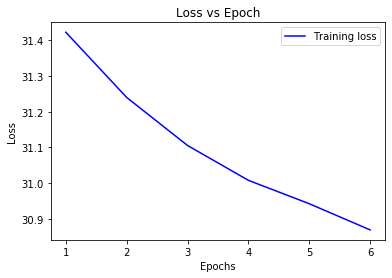

In [28]:
epochs = range(1,EPOCHS + 1)
plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.title('Loss vs Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluation
I use the test dataloader to get results for the test dataset.

In [29]:
model.eval()
y_pred = torch.Tensor().to(device)    
with torch.no_grad(): #deactivating torch autograd during evaluation.
    #To observe real-time progress of the model training I have used tqdm library
    tqdm_dataloader = tqdm_notebook(enumerate(test_dataloader),total =(len(X_test) / BATCH_SIZE) )

    for step_num, data in tqdm_dataloader:
        classes , _ = tuple(t.to(device) for t in batch) #otaining data from the dataloader
        classes = classes.float()
        logits = model(classes)
        y_pred = torch.cat((y_pred,logits), 0)           #storing the outputs


# Formatting the results
Taking the tensor outputs from evaluation phase and converting them into the csv file for submission.

In [30]:
preds = list(map(lambda x: x.item(),list(y_pred.cpu().numpy())))

In [31]:
preds = [max(min(x, 20.0), 0.0) for x in preds] # placing limits on the minimum and maximum values the preds are allowed to attain.

Creating dataframe with required columns.

In [32]:
submission = pd.DataFrame({'ID':test_data['ID'],'item_cnt_month':preds})

In [33]:
submission.head()

,ID,item_cnt_month
0,0,0.132305
1,1,0.126106
2,2,0.126106
3,3,0.126468
4,4,0.256086


Creating csv file from dataframe.

In [34]:
submission.to_csv(r'D:\Kaggle\datasets\competitive-data-science-predict-future-sales/submission2.csv',index = False,header = True)